# Network Science Project

In [1]:
%matplotlib inline
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import powerlaw

These are the functions used.

In [2]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def create_distribution(k_list, nbins):
    kmin = min(k_list)
    kmax = max(k_list)
    
    # Get nbins logarithmically spaced bins between kmin and kmax
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=nbins)

    # histogram the data into these bins
    pk, _ = np.histogram(k_list, bins=bin_edges, density=True)
    log_be = np.log10(bin_edges)
    k = 10**((log_be[1:] + log_be[:-1])/2)
    # Some times there are empty bins and they create problems. Remove them
    x = []
    y = []
    for i in range(len(pk)):
        if pk[i] != 0:
            x.append(k[i])
            y.append(pk[i])
    return x, y

def calculate_fit(x, y, m_true = -2.0, b_true = -1.0, f_true=1.5):
    yerr = np.zeros(len(y))  # We do not have y error

    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [m_true, b_true, np.log(f_true)],
                         args=(np.log10(x), np.log10(y), yerr))
    m_ml, b_ml, lnf_ml = result["x"]
    return m_ml, b_ml

def get_deg_dist(k_list):
    degdist = {}
    for i in range(1,max(k_list)):
        Nk = k_list.count(i)
        if Nk != 0:
            degdist[i] = Nk/N
    return degdist

def add_value(knn, k_self, avgndeg):
    if k_self in knn:
        knn[k_self][0] += 1
        knn[k_self][1] += avgndeg
    else:
        knn[k_self] = [1, avgndeg]

def calculate_deg_cor_func(G, s):
    knn = {}
    if s == 'ii':
        for n in G.nodes():
            k_self = G.in_degree(n)  # Here we are ignoring k = 0 scenario
            if k_self != 0:
                avgndeg = sum(G.in_degree(G.neighbors(n)).values())/k_self
                add_value(knn, k_self, avgndeg)
    elif s == 'io':
        for n in G.nodes():
            k_self = G.in_degree(n)  # Here we are ignoring k = 0 scenario
            if k_self != 0:
                avgndeg = sum(G.out_degree(G.neighbors(n)).values())/k_self
                add_value(knn, k_self, avgndeg)
    elif s == 'oi':
        for n in G.nodes():
            k_self = G.out_degree(n)  # Here we are ignoring k = 0 scenario
            if k_self != 0:
                avgndeg = sum(G.in_degree(G.neighbors(n)).values())/k_self
                add_value(knn, k_self, avgndeg)
    elif s == 'oo':
        for n in G.nodes():
            k_self = G.out_degree(n)  # Here we are ignoring k = 0 scenario
            if k_self != 0:
                avgndeg = sum(G.out_degree(G.neighbors(n)).values())/k_self
                add_value(knn, k_self, avgndeg)
    else:
        print('Invalid option for degree correlation:',s)
        return None
    
    knn_final = []
    k = []
    for deg, det in knn.items():
        if det[1] != 0:
            k.append(deg)
            knn_final.append(det[1]/det[0])
    return k, knn_final

def deg_pres_rand(G, nswaps=1):
    i = 1
    
    while i <= nswaps:
        nlist = []
        for n in G.nodes():
            if len(G.neighbors(n)) >= 2:  # Get nodes with out degrees >= 1
                nlist.append(n)
        if len(nlist) <= 2:
            print('Not enough nodes')
            return None
        S1, S2 = np.random.choice(nlist, 2)
        if len(G.neighbors(S1)) == 1:
            T1 = G.neighbors(S1)[0]
        else:
            T1 = np.random.choice(G.neighbors(S1))
        if len(G.neighbors(S2)) == 1:
            T2 = G.neighbors(S2)[0]
        else:
            T2 = np.random.choice(G.neighbors(S2))
        G.add_edge(S1, T2)
        G.add_edge(S2, T1)
        if G.has_edge(S1, T1) == False:
            print('No edge:', S1, T1)
            print('Neighbors of S1:',G.neighbors(S1))
            print(S1,T1,S2,T2)
        if G.has_edge(S2, T2) == False:
            print('No edge:', S2, T2)
            print('Neighbors of S1:',G.neighbors(S2))
            print(S1,T1,S2,T2)
        G.remove_edge(S1, T1)
        G.remove_edge(S2, T2)
        i += 1
    return G

Open the data file, read data and create directed graph.

In [3]:
with open('data.json', 'r') as fo:
    jsdata = json.load(fo)
    
G = nx.DiGraph()
G.add_edges_from([(d,m['name']) for m in jsdata for d in m['dependencies']])
print('Total number of nodes in the graph:', G.number_of_nodes())

Total number of nodes in the graph: 11961


In the graph, there is a giant component and several small disconnected components. We consider only the giant component. Here we extract the giant component. 

In degree = This inherits from others 

Out degree = Others inherit from this

In [4]:
G = max(nx.weakly_connected_component_subgraphs(G), key=len)
nx.write_graphml(G, 'giantcompdir.graphml')  # Need .graphml file for visualization
G_undir = G.to_undirected()  # Create undir graph since some calculations need undir graph
N = G.number_of_nodes()
k_in_list = sorted(G.in_degree().values(), reverse=True)
k_out_list = sorted(G.out_degree().values(), reverse=True)
k_list = sorted(G_undir.degree().values(), reverse=True)
k_ranges = {'kin':(min(k_in_list), max(k_in_list)), 'kout':(min(k_out_list), max(k_out_list)),
           'k':(min(k_list), max(k_list))}

# Count number of 0 degrees in in and out degree lists
kin_0 = k_in_list.count(0)
kout_0 = k_out_list.count(0)

# Remove 0s since it causes problems in loglog plot
k_in_list = [x for x in k_in_list if x != 0]  
k_out_list = [x for x in k_out_list if x != 0] 

degdist_in = get_deg_dist(k_in_list)  # Degree distribution of in degree list
degdist_out = get_deg_dist(k_out_list)  # Degree distribution of out degree list
degdist = get_deg_dist(k_list)    # Degree distribution of undirected degree list

N_edges = len(G.in_edges())
kave = N_edges/N

print('Size of the giant component:', N)
print('Number of 0s in in degree list:', kin_0)
print('Number of 0s in out degree list:', kout_0)
print('Range of kin and kout:', k_ranges)
print('Average k:', '{:6.4f}'.format(kave))
print('Number edges(All are directed):', N_edges)

Size of the giant component: 11412
Number of 0s in in degree list: 5003
Number of 0s in out degree list: 3443
Range of kin and kout: {'k': (1, 761), 'kout': (0, 761), 'kin': (0, 82)}
Average k: 2.5727
Number edges(All are directed): 29360


As shown above, there are a large number of nodes with 0 in degree and 0 out degree in the giant component. Therefore just calculating the average distance between nodes in the original directed graph is insufficient. Therefore, in addition to that, the directed graph is converted to an undirected graph and average distance is calulated. 

In [20]:
ave_dist_dir = nx.average_shortest_path_length(G)
ave_dist_undir = nx.average_shortest_path_length(G_undir)
print('Average distance in the directed graph:{:8.4f}'.format(ave_dist_dir))
print('Average distance in the undirected graph:{:8.4f}'.format(ave_dist_undir))

Average distance in the directed graph:  0.0055
Average distance in the undirected graph:  4.7895


Then the information about clustering of nodes is found. Here only undirected graph is considered since clustering algorithms are not degfined for directed graphs.

In [22]:
G_undir_clus = nx.clustering(G_undir)
G_ave_clus_undir = nx.average_clustering(G_undir)
print('Average clustering coefficient of undiracted graph:{:8.4f}'.format(G_ave_clus_undir))

Average clustering coefficient of undiracted graph:  0.0933


Here we make the fit for in and out degrees using maximum likelihood method. Our error in y coordinate is 0.

In [23]:
r1 = powerlaw.Fit(k_in_list)
r2 = powerlaw.Fit(k_out_list)
print('Degree exponent for in degrees:',r1.power_law.alpha)
print('Degree exponent for out degrees:',r2.power_law.alpha)

Degree exponent for in degrees: 3.06153177589
Degree exponent for out degrees: 2.37486434652


Calculating best minimal value for power law fit
//anaconda/lib/python3.5/site-packages/powerlaw.py:692: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


In [14]:
k_in, pk_in = create_distribution(k_in_list, 20)
m_in, b_in = calculate_fit(k_in, pk_in)
yin = (10**b_in) * (k_in**m_in)
print('Degree exponent of in degrees, gamma in:', m_in)

Degree exponent of in degrees, gamma in: -2.01524806853


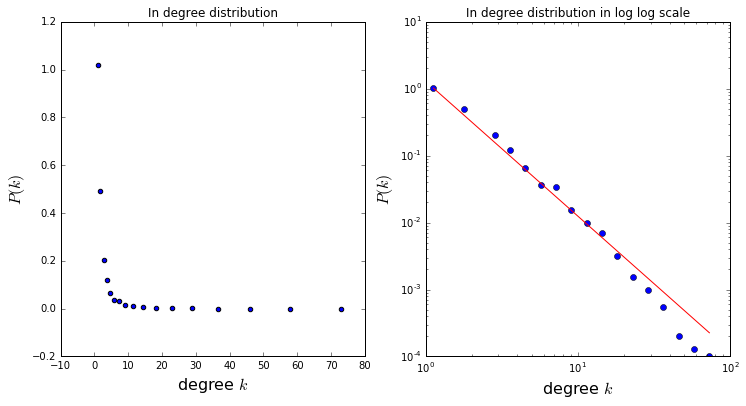

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(k_in, pk_in)
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('In degree distribution')

plt.subplot(122)
plt.loglog(k_in, pk_in, marker='o', linestyle='none')
plt.loglog(k_in, yin, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('In degree distribution in log log scale')
plt.show()

In [14]:
dat = []
for nbins in [20,25,30,35,40,45]:
    k_out, pk_out = create_distribution(k_out_list, nbins)
    m_out, b_out = calculate_fit(k_out, pk_out)
    yout = (10**b_out) * (k_out**m_out)
    print('Number of bins:', nbins, '  gamma out:', m_out)
    dat.append((k_out, pk_out, yout))

Number of bins: 20   gamma out: -1.74930644814
Number of bins: 25   gamma out: -1.61660311842
Number of bins: 30   gamma out: -1.51976094616
Number of bins: 35   gamma out: -1.49424428364
Number of bins: 40   gamma out: -1.46224190504
Number of bins: 45   gamma out: -1.43786084556


Here we have a problem. Based on the number of bins, degree exponent of out degrees, gamma out seems to be changing dramatically. This has to be addressed.

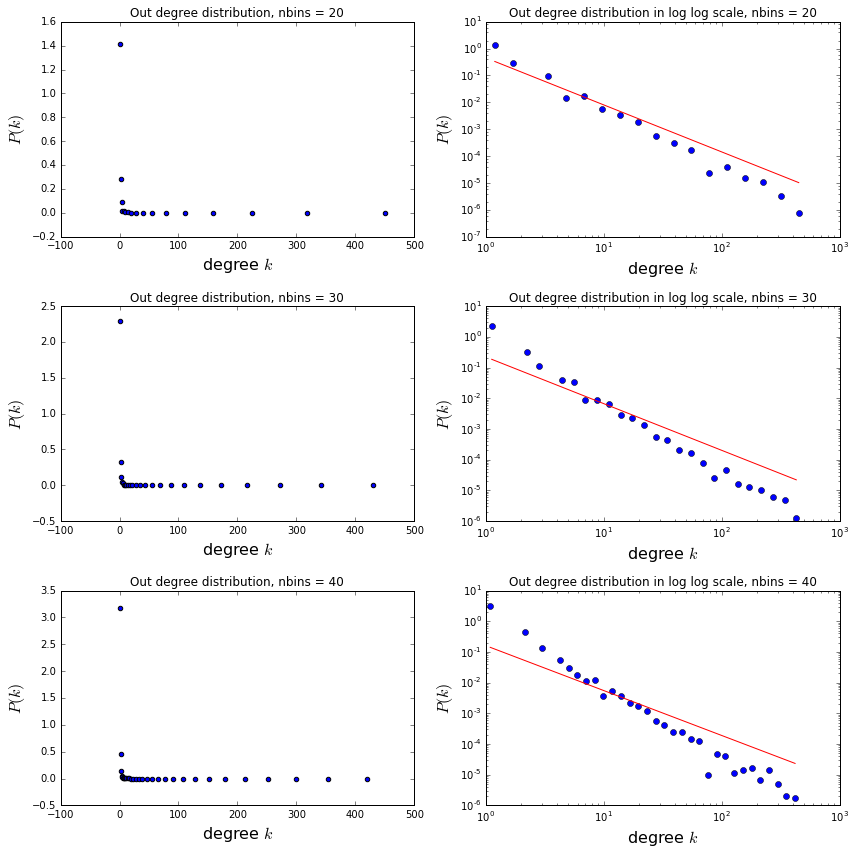

In [16]:
fig = plt.figure(figsize=(12,12))
plt.subplot(321)
plt.scatter(dat[0][0], dat[0][1])
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution, nbins = 20')

plt.subplot(322)
plt.loglog(dat[0][0], dat[0][1], marker='o', linestyle='none')
plt.loglog(dat[0][0], dat[0][2], color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution in log log scale, nbins = 20')

plt.subplot(323)
plt.scatter(dat[2][0], dat[2][1])
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution, nbins = 30')

plt.subplot(324)
plt.loglog(dat[2][0], dat[2][1], marker='o', linestyle='none')
plt.loglog(dat[2][0], dat[2][2], color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution in log log scale, nbins = 30')

plt.subplot(325)
plt.scatter(dat[4][0], dat[4][1])
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution, nbins = 40')

plt.subplot(326)
plt.loglog(dat[4][0], dat[4][1], marker='o', linestyle='none')
plt.loglog(dat[4][0], dat[4][2], color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title('Out degree distribution in log log scale, nbins = 40')

plt.tight_layout()
plt.show()

## Degree correlation

### Measuring degree correlation 

Here degree correlation function is calculated. 

In [7]:
kii, knnii = calculate_deg_cor_func(G, 'ii')
kio, knnio = calculate_deg_cor_func(G, 'io')        
koi, knnoi = calculate_deg_cor_func(G, 'oi')
koo, knnoo = calculate_deg_cor_func(G, 'oo')
ks = (kave * N)**0.5
print('Structural cutoff:{0:9.4f}'.format(ks))

Structural cutoff: 171.3476


Then the fit for each is calculated.

In [16]:
mu_ii = -1.098
a_ii = 10**1.49
knnii_fit = [a_ii * (k**mu_ii) for k in kii]

mu_io = -1.322
a_io = 10**0.6646
knnio_fit = [a_io * (k**mu_io) for k in kio]

mu_oi = -0.1158
a_oi = 10**1.24
knnoi_fit = [a_oi * (k**mu_oi) for k in koi]

mu_oo = -0.1439
a_oo = 10**0.5092
knnoo_fit = [a_oo * (k**mu_oo) for k in koo]

In [12]:
# For preocessing in matlab
np.savetxt('ii.txt', (kii, knnii))
np.savetxt('io.txt', (kio, knnio))
np.savetxt('oi.txt', (koi, knnoi))
np.savetxt('oo.txt', (koo, knnoo))

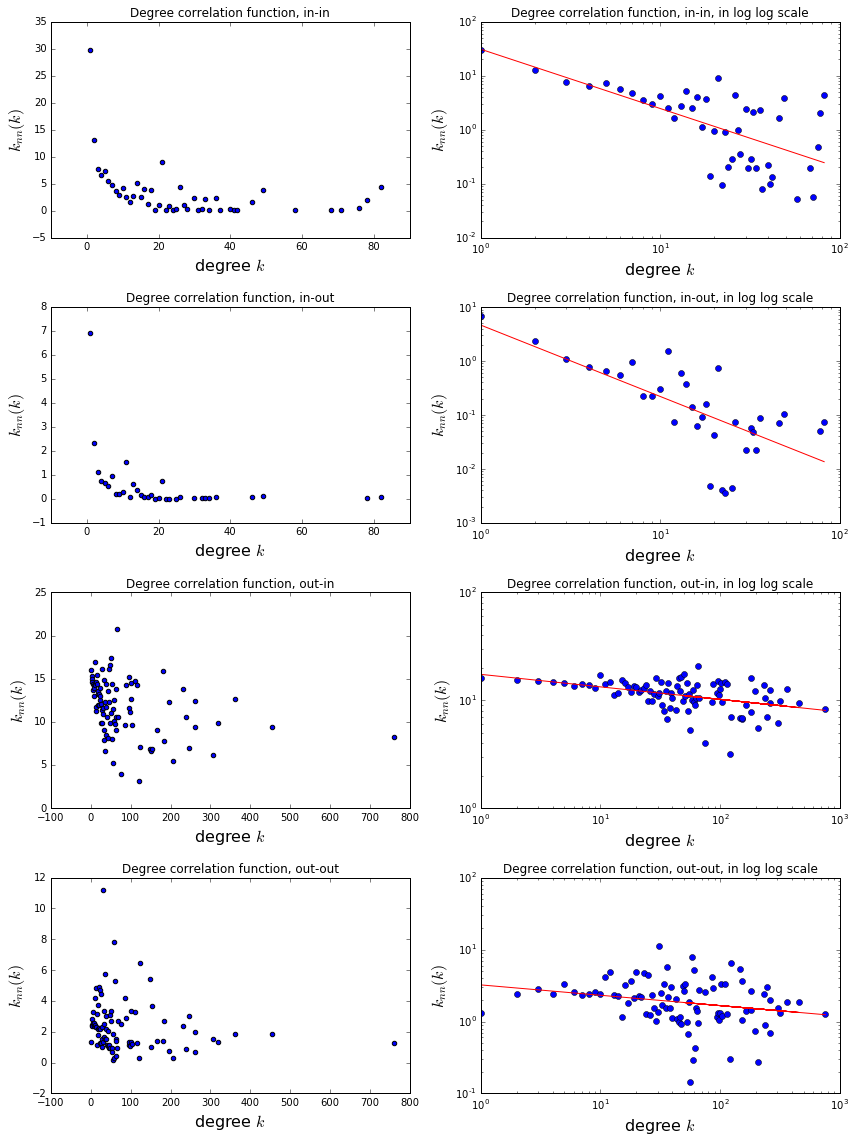

In [17]:
fig = plt.figure(figsize=(12,16))

###################### In-In #####################################
plt.subplot(421)
plt.scatter(kii, knnii)
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-in')

plt.subplot(422)
plt.loglog(kii, knnii, marker='o', linestyle='none')
plt.loglog(kii, knnii_fit, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-in, in log log scale')

###################### In-Out #####################################

plt.subplot(423)
plt.scatter(kio, knnio)
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-out')

plt.subplot(424)
plt.loglog(kio, knnio, marker='o', linestyle='none')
plt.loglog(kio, knnio_fit, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-out, in log log scale')

###################### Out-In #####################################

plt.subplot(425)
plt.scatter(koi, knnoi)
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, out-in')

plt.subplot(426)
plt.loglog(koi, knnoi, marker='o', linestyle='none')
plt.loglog(koi, knnoi_fit, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, out-in, in log log scale')

###################### Out-Out #####################################

plt.subplot(427)
plt.scatter(koo, knnoo)
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, out-out')

plt.subplot(428)
plt.loglog(koo, knnoo, marker='o', linestyle='none')
plt.loglog(koo, knnoo_fit, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, out-out, in log log scale')

plt.tight_layout()
plt.show()
#fig.savefig('DegCor.png')

In [50]:
nswaps = 1000
Gtemp = G.copy()  # Create a copy for degree preserving randomization
deg_pres_rand(Gtemp, nswaps)
kii_t, knnii_t = calculate_deg_cor_func(Gtemp, 'ii')
print('ii done')
Gtemp = G.copy()  # Create a copy for degree preserving randomization
deg_pres_rand(Gtemp, nswaps)
kio_t, knnio_t = calculate_deg_cor_func(Gtemp, 'io')
print('io done')

done
done


Below, we plot the degree correlation after degree preserving randomization. Here we pay attention only to ii and io scenarios only they show a significant assortivity.

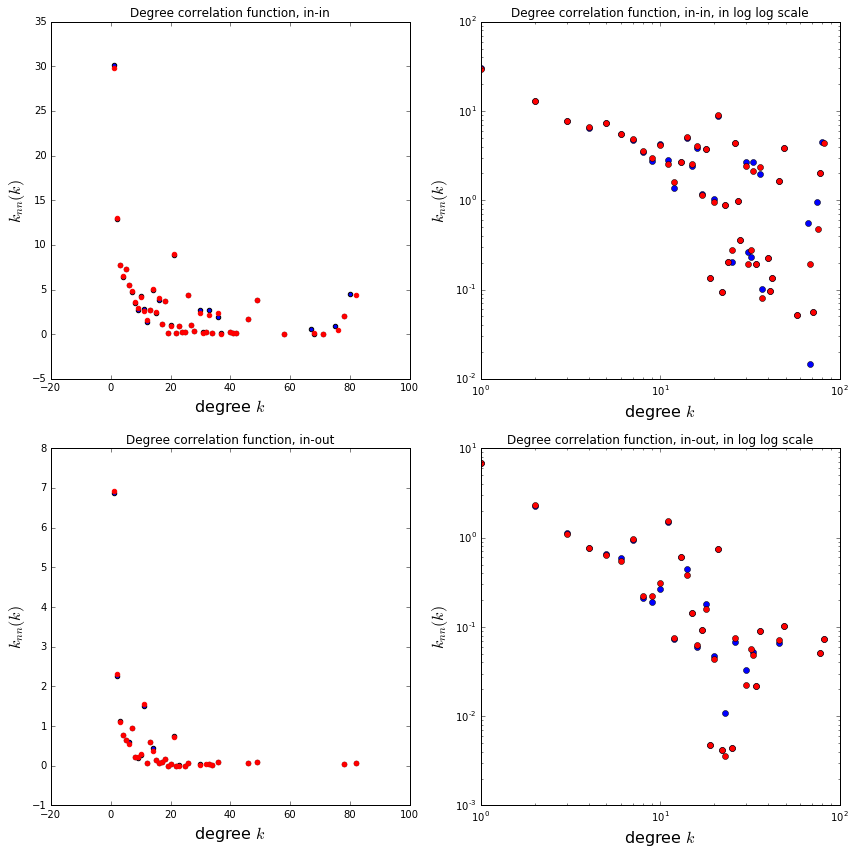

In [51]:
fig = plt.figure(figsize=(12,12))

###################### In-In #####################################
plt.subplot(221)
plt.scatter(kii_t, knnii_t)
plt.scatter(kii, knnii, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-in')

plt.subplot(222)
plt.loglog(kii_t, knnii_t, marker='o', linestyle='none')
plt.loglog(kii, knnii, marker='o', linestyle='none', color='red')
#plt.loglog(kii_t, knnii_fit, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-in, in log log scale')

###################### In-Out #####################################

plt.subplot(223)
plt.scatter(kio_t, knnio_t)
plt.scatter(kio, knnio, color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-out')

plt.subplot(224)
plt.loglog(kio_t, knnio_t, marker='o', linestyle='none')
plt.loglog(kio, knnio, marker='o', linestyle='none', color='red')
#plt.loglog(dat[0][0], dat[0][2], color='red')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$k_{nn}(k)$", fontsize=16)
plt.title('Degree correlation function, in-out, in log log scale')

plt.tight_layout()
plt.show()

From the above plots we can see that, degree preserving randomization has not changed the degree correlation significantly. Therefore, we can conclude that by nature, this network shows disassocitivity. 

### Pearson degree correlation coefficients. 

In [6]:
rii = nx.degree_pearson_correlation_coefficient(G, x='in', y='in')
rio = nx.degree_pearson_correlation_coefficient(G, x='in', y='out')
roi = nx.degree_pearson_correlation_coefficient(G, x='out', y='in')
roo = nx.degree_pearson_correlation_coefficient(G, x='out', y='out')
print('rii:', rii)
print('rio:', rio)
print('roi:', roi)
print('roo:', roo)

rii 0.0430598508909
rio -0.0231484929445
roi -0.107469929554
roo -0.019061951697


From results, according to the algorithm of degree correlation function, we expect disassortivity for all four scenarios, therefore, negative Pearson coefficients for all. However, Pearson coefficent calculated from the networkx is unexpectedly positive for the first case which shows a significant disassortivity. This remains unanswered.